In [156]:
from pcmdpy import gpu_utils, instrument as ins
import time

In [176]:
import numpy as np, matplotlib.pyplot as plt, matplotlib as mpl
from scipy.misc import ascent
from scipy.signal import fftconvolve
from tqdm import tqdm
%matplotlib inline

In [113]:
from scipy import misc

In [3]:
from pycuda import gpuarray

In [4]:
from scipy import signal

In [5]:
from pyfft.cuda import Plan

In [6]:
gpu_utils.initialize_gpu(n=0)

using given n: 0
Starting SourceModule Code
Getting function
Past the SourceModule code
CUDAC Available


In [7]:
from pcmdpy import instrument as ins

In [93]:
f = ins.Filter.HST_F475W(10.)
psf = f._psf[0,0]
psf.shape

(73, 73)

In [175]:
gauss_kernel = np.outer(signal.gaussian(128, 3), signal.gaussian(128, 3))
gauss_kernel.shape

(128, 128)

In [117]:
image = ascent()
image.shape

(512, 512)

In [194]:
image_huge = np.tile(image, (16, 16))
image_huge.shape

(8192, 8192)

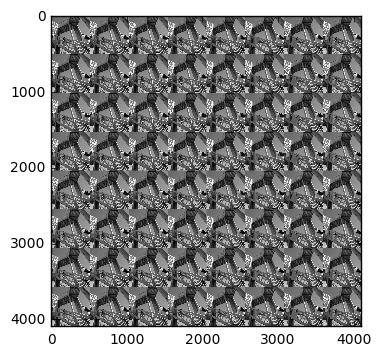

In [164]:
plt.imshow(image_huge,cmap='Greys_r')

In [165]:
def next_power2(n):
    return int(2**np.ceil(np.log2(n)))

In [166]:
def assert_valid_dims(in1, in2):
    try:
        assert(in1.ndim == in2.ndim)
    except:
        raise AssertionError('Input arrays must have same dimensions')

In [167]:
def get_shapes(in1, in2):
    assert_valid_dims(in1, in2)
    s1, s2 = np.array(in1.shape), np.array(in2.shape)
    fshape = [next_power2(s1[i] + s2[i] - 1) for i in range(in1.ndim)]
    return s1, s2, fshape

In [168]:
def pad_end(a, new_shape):
    new_shape = tuple(new_shape)
    assert(a.ndim == len(new_shape))
    assert(a.shape <= new_shape)
    s_temp = np.array(a.shape)
    return np.pad(a, [(0, new_shape[i] - s_temp[i]) for i in range(a.ndim)], 'constant')

In [169]:
def pad_both(in1, in2):
    assert_valid_dims(in1, in2)
    ndim = in1.ndim
    s1, s2, fshape = get_shapes(in1, in2)
    fslice = tuple([slice(0, int(s1[i]+s2[i]-1)) for i in range(ndim)])
    pad1 = [(0,fshape[i] - s1[i]) for i in range(ndim)]
    pad2 = [(0,fshape[i] - s2[i]) for i in range(ndim)]
    new1 = np.pad(in1, pad1, 'constant')
    new2 = np.pad(in2, pad2, 'constant')
    return new1, new2, fslice

In [170]:
#borrowed from scipy.signal.signaltools
def _centered(arr, newsize):
    # Return the center newsize portion of the array.
    newsize = np.asarray(newsize)
    currsize = np.array(arr.shape)
    startind = (currsize - newsize) // 2
    endind = startind + newsize
    myslice = [slice(startind[k], endind[k]) for k in range(len(endind))]
    return arr[tuple(myslice)]

In [171]:
def fftconvolve_gpu(in1, in2, mode='valid', plan=None, real=True):
    if mode not in ['valid', 'same', 'full']:
        raise NotImplementedError('Acceptable mode flags are "valid", "same", and "full"')
    assert_valid_dims(in1, in2)
    in1 = in1.astype(np.complex64)
    in2 = in2.astype(np.complex64)
    s1, s2, fshape = get_shapes(in1, in2)
    if plan is None:
        plan = Plan(tuple(fshape))
    in1, in2, fslice = pad_both(in1, in2)
    in1_g = gpuarray.to_gpu(in1)
    in2_g = gpuarray.to_gpu(in2)
    plan.execute(in1_g)
    plan.execute(in2_g)
    
    convolved_g = in1_g * in2_g
    plan.execute(convolved_g, inverse=True)
    result = convolved_g[fslice].get()
    
    if real:
        result = np.real(result)
    if mode == 'valid':
        return _centered(result, s1-s2+1)
    elif mode == 'same':
        return _centered(result, s1)
    elif mode == 'full':
        return result
    else:
        raise NotImplementedError('Acceptable mode flags are "valid", "same", and "full"')

In [172]:
class GPU_convolver:
    
    def __init__(self, psf, image_shape):
        self.psf = psf
        self.psf_shape = np.array(self.psf.shape)
        self.ndim = self.psf.ndim
        assert(self.ndim == len(image_shape))
        self.image_shape = np.array(image_shape)
        self.fslice = tuple([slice(0, int(self.image_shape[i]+self.psf_shape[i]-1))
                             for i in range(self.ndim)])
        
        self.fshape = tuple([next_power2(self.image_shape[i] + self.psf_shape[i] - 1) for i in range(self.ndim)])
        psf_temp = pad_end(self.psf, self.fshape).astype(np.complex64)

        self.plan = Plan(self.fshape)
        
        self.psf_g = gpuarray.to_gpu(psf_temp)
        self.plan.execute(self.psf_g)
        
    def reset_psf(self, psf):
        self.psf = psf
        self.psf_shape = np.array(self.psf.shape)
        self.ndim = self.psf.ndim
        assert(self.ndim == len(self.image_shape))
        self.fslice = tuple([slice(0, int(self.image_shape[i]+self.psf_shape[i]-1))
                             for i in range(self.ndim)])
        
        self.fshape = tuple([next_power2(self.image_shape[i] + self.psf_shape[i] - 1) for i in range(self.ndim)])

        psf_temp = pad_end(psf, self.fshape).astype(np.complex64)

        self.plan = Plan(self.fshape)
        
        self.psf_g = gpuarray.to_gpu(psf_temp)
        self.plan.execute(self.psf_g)
        
    def reset_image_shape(self, image_shape):
        self.image_shape = np.array(image_shape)
        assert(self.ndim == len(self.image_shape))
        self.fslice = tuple([slice(0, int(self.image_shape[i]+self.psf_shape[i]-1))
                             for i in range(self.ndim)])
        self.fshape = tuple([next_power2(self.image_shape[i] + self.psf_shape[i] - 1) for i in range(self.ndim)])
        
        psf_temp = pad_end(psf, self.fshape).astype(np.complex64)
        self.plan = Plan(self.fshape)
        self.psf_g = gpuarray.to_gpu(psf_temp)
        self.plan.execute(self.psf_g)
        
    def fftconvolve(self, image, real=True, mode='valid'):
        if mode not in ['valid', 'same', 'full']:
            raise NotImplementedError('Acceptable mode flags are "valid", "same", and "full"')
        try:
            assert(image.shape == tuple(self.image_shape))
        except:
            raise AssertionError('Image is required to have shape: ' + str(self.image_shape)
                                 + ' , not: ' + str(image.shape))
            
        image_pad = pad_end(image, self.fshape).astype(np.complex64)
        im_g = gpuarray.to_gpu(image_pad)
        self.plan.execute(im_g)
        
        convolved_g = im_g * self.psf_g
        self.plan.execute(convolved_g, inverse=True)
        result = convolved_g[self.fslice].get()
    
        if real:
            result = np.real(result)
        if mode == 'valid':
            return _centered(result, self.image_shape-self.psf_shape+1)
        elif mode == 'same':
            return _centered(result, self.image_shape)
        elif mode == 'full':
            return result
        else:
            raise NotImplementedError('Acceptable mode flags are "valid", "same", and "full"')

In [203]:
kernel = psf
times_cpu = []
times_gpu = []
# sizes = [128, 200, 256, 400, 512, 800, 1024, 1500, 2048, 3000, 4096]
sizes = [128, 256, 512, 1024, 2048, 4096]
convolver = GPU_convolver(g_kernel, image.shape)
for d in tqdm(sizes):
    im = image_huge[:d, :d]
    #cpu test
    start = time.time()
    _ = fftconvolve(im, kernel, mode='same')
    times_cpu.append(time.time()-start)
    #gpu test
    convolver.reset_image_shape(im.shape)
    start = time.time()
    _ = convolver.fftconvolve(im, real=True, mode='valid')
    times_gpu.append(time.time()-start)

100%|██████████| 6/6 [00:08<00:00,  2.34s/it]▎      | 2/6 [00:00<00:00, 19.64it/s]


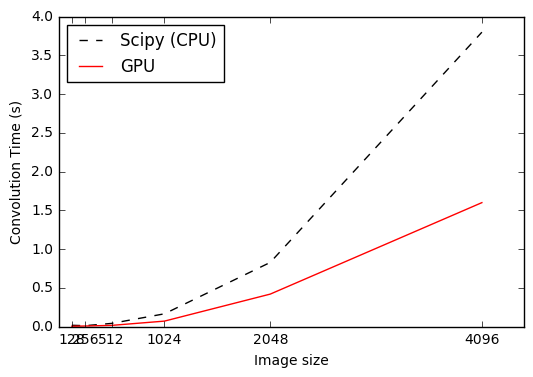

In [204]:
plt.plot(sizes, times_cpu, 'k--', label='Scipy (CPU)')
plt.plot(sizes, times_gpu, 'r-', label='GPU')
plt.ylabel('Convolution Time (s)')
plt.xticks(sizes), plt.xlabel('Image size')
plt.legend(loc=0)
plt.savefig('figures/GPU_convolution.pdf')